In [1]:
#%matplotlib notebook


In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch,Rectangle,Arrow,FancyArrow
import json
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# load data
filename = 'Lipid_fatty_acids_geno_chr4_9_PS.csv'
df = pd.read_csv(filename, index_col="Genotype")

# treat everything as numbers
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [3]:
df.columns

Index(['chr4', 'chr9', 'MGDG', 'DGDG', 'SQDG', 'PG', 'PIPE', 'PC', 'PG_16_0',
       'PG_16_1', 'PG_18_0', 'PG_18_2', 'PG_18_3', 'MGDG_16_0', 'MGDG_18_2',
       'MGDG_18_3', 'DGDG_16_0', 'DGDG_18_2', 'DGDG_18_3', 'PC_16_0',
       'PC_18_1', 'PC_18_2', 'PC_18_3', 'SQDG_16_0', 'SQDG_18_0', 'SQDG_18_1',
       'SQDG_18_2', 'SQDG_18_3', 'PEPI_16_0', 'PEPI_18_1', 'PEPI_18_2',
       'PEPI_18_3', 'DGDG/MGDG', 'LT_DEPI_phi2_81', 'LT_DEPI_qIt_81',
       'LT_DEPI_qL_81'],
      dtype='object')

In [4]:
# settings for histograms with arrows

all_arrow_colors = {
    "CB27": "red",
    "24-125B-1": "blue"
}

all_condition_prefixes = {
    # label in legend: column name prefix
    "chilling": "cold",
    "control": "control"
}

all_hist_colors = {
    "chilling": "blue",
    "control": "orange"
}

all_arrow_linestyles = {
    "chilling": "--",
    "control": "-"
}


arrow_length = .1 # a fraction of the axis height

# make a figure with a histogram, some arrows, and a special legend
def march_2021_figure(para,n_bins,bin_range,xlabel=None):
    
    # make a figure with two "subplots" that can be repositioned
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_axes([.1,.1,.4,.8]) 
    legend_ax = fig.add_axes([.55,.1,.4,.8])

    # collect all the data that will be involved in this plot
    # for each condition we have a pandas series where the index contains genotypes
    hist_values_by_condition = {
        condition:df["_".join([prefix,para])] 
        for condition,prefix in all_condition_prefixes.items()
    }
    
    # compare two groups
    # show the p-value
    group_a = hist_values_by_condition["control"]
    group_b = hist_values_by_condition["chilling"]
    pval = stats.ks_2samp(group_a,group_b).pvalue
    ax.text( .04,.92, "p-value: {0:.2e}".format(pval), transform=ax.transAxes, fontsize=14 )

    # draw histograms and collect info about them
    # for each condition we have a list of bins and a list of freqs
    hist_info_by_condition = {
        condition:ax.hist(values, 
                           bins=n_bins, range=bin_range,
                           alpha=.3, color=all_hist_colors[condition])[:2]
        for condition,values in hist_values_by_condition.items()
    }

    # add arrows to histograms
    ylim = ax.get_ylim()
    dy = arrow_length * (ylim[1] - ylim[0])
    for condition,(freqs,bins) in hist_info_by_condition.items():
        hist_values = hist_values_by_condition[condition]
        for genotype,color in all_arrow_colors.items():
            x = hist_values[genotype]
            try:
                bin_index = next(i for i,b in enumerate(bins) if b>x)-1
                y = freqs[bin_index]
            except:
                y = 0
            ax.annotate("", xy=(x,y), xytext=(x, y+dy), 
                         arrowprops=dict(arrowstyle="->",color=color,linestyle=all_arrow_linestyles[condition]))



    #hist_with_arrows(df['cold_DEPI_phi2'],arrow_style="--",range =[0,0.6],color='blue',alpha=0.3,bins =bins,label="chilling")
    #hist_with_arrows(df['control_DEPI_phi2'],range =[0,0.6],color='orange',alpha=0.3,bins =bins,label="control")
    if xlabel is None:
        xlabel = para
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("Number of lines", fontsize=14)
    #plt.legend('cold_DEPI_phi2','control_DEPI_phi2')
    #plt.savefig("phi2",dpi=600)


    # make a special legend
    v = hist_values_by_condition
    group_rows = {
        condition:[
            None,condition,
            Rectangle((0,0),.1,.05,facecolor=color,alpha=.3),
            np.mean(v[condition]),
            np.std(v[condition])
        ] 
        for condition,color in all_hist_colors.items()
    }
    arrow_rows = {
        condition:[
            None,condition,None,
            Arrow(0,0,0,0,color=all_arrow_colors["CB27"],linestyle=linestyle),
            Arrow(0,0,0,0,color=all_arrow_colors["24-125B-1"],linestyle=linestyle),
        ]
        for condition,linestyle in all_arrow_linestyles.items()
    }
    legend_x = [.1,.25,.4,.55,.7]
    legend_y = [.8,.7,.6,.4,.3,.2]
    legend_values = [
        ["Group",None,None,"Mean","Std"],
        group_rows["control"],
        group_rows["chilling"],
        ["Arrow",None,None,"CB27","24-125B-1"],
        arrow_rows["control"],
        arrow_rows["chilling"]
    ]
    legend_ax.axis(False)
    for iy,y in enumerate(legend_y):
        for ix,x in enumerate(legend_x):
            val = legend_values[iy][ix]
            if val is None:
                continue
            if isinstance(val,float):
                if val < .01:
                    f = "{0:.0e}"
                elif val > 10:
                    f = "{0:.1f}"
                else:  
                    f = "{0:.3f}"
                val = f.format(val)
            if isinstance(val,str):
                legend_ax.text(x,y,val,fontsize=14)
            if isinstance(val,Rectangle):
                val.set_xy((x+.02,y-.01))
                legend_ax.add_patch(val)
            if isinstance(val,Arrow):
                legend_ax.add_patch(
                    FancyArrow(x+.05,y+.05,0,-.05,color=val.get_edgecolor(),linestyle=val.get_ls(),
                               width=0,head_width=.01))

    legend_ax.add_patch(Rectangle((.05,.1),.9,.4,fill=None,edgecolor="black"))

# draw a histogram with arrows on the current pyplot figure
# this can be used the same way as plt.hist
# hist_values must by a pandas series with genotype names in the index
def hist_with_arrows( hist_values, arrow_style="-", **kwargs ):
    freqs,bins,_ = plt.hist(hist_values,**kwargs)
    
    ylim = plt.ylim()
    dy = arrow_length * (ylim[1] - ylim[0])
    
    for genotype,color in all_arrow_colors.items():
        x = hist_values[genotype]
        try:
            bin_index = next(i for i,b in enumerate(bins) if b>x)-1
            y = freqs[bin_index]
        except:
            y = 0
        plt.annotate("", xy=(x,y), xytext=(x, y+dy), 
                     arrowprops=dict(arrowstyle="->",color=color,linestyle=arrow_style))
        
    print( "{0}\n\tmean: {1:.3f}\n\tstd: {2:.3f}\n".format( 
        hist_values.name, np.mean(hist_values), np.std(hist_values) ) )

MGDG
	mean: 32.214
	std: 1.425



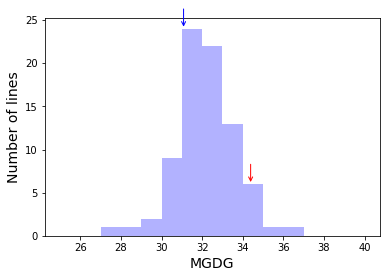

In [5]:
#lipid 
plt.figure()
bins = 15
para = 'MGDG'
hist_with_arrows(df[para],range =[25,40],color='blue',alpha=0.3,bins =bins)

plt.xlabel(para, fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

DGDG
	mean: 22.436
	std: 1.376



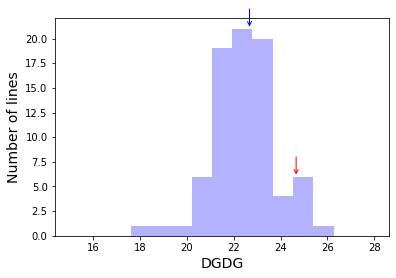

In [28]:
#lipid 
plt.figure()
bins = 15
para = 'DGDG'
hist_with_arrows(df[para],range =[15,28],color='blue',alpha=0.3,bins =bins)

plt.xlabel(para, fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

SQDG
	mean: 5.269
	std: 0.483



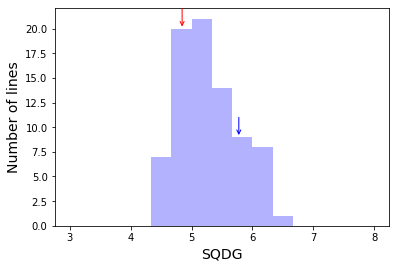

In [29]:
#lipid 
plt.figure()
bins = 15
para = 'SQDG'
hist_with_arrows(df[para],range =[3,8],color='blue',alpha=0.3,bins =bins)

plt.xlabel(para, fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PG
	mean: 11.519
	std: 0.831



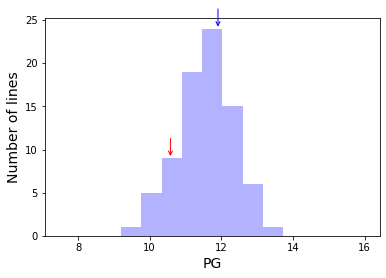

In [30]:
#lipid 
plt.figure()
bins = 15
para = 'PG'
hist_with_arrows(df[para],range =[7.5,16],color='blue',alpha=0.3,bins =bins)

plt.xlabel(para, fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PIPE
	mean: 11.134
	std: 1.122



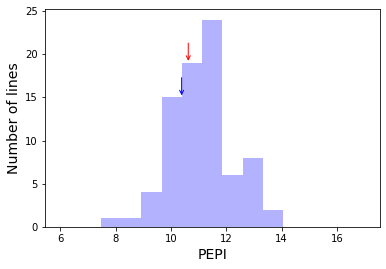

In [31]:
#lipid 
plt.figure()
bins = 15
para = 'PIPE'
hist_with_arrows(df[para],range =[6,17],color='blue',alpha=0.3,bins =bins)

plt.xlabel("PEPI", fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)

plt.show()


PC
	mean: 16.648
	std: 1.081



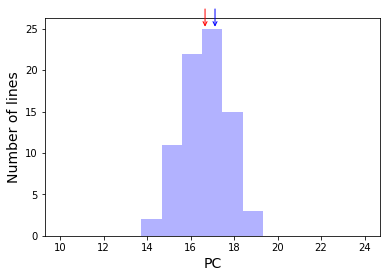

In [32]:
#lipid 
plt.figure()
bins = 15
para = 'PC'
hist_with_arrows(df[para],range =[10,24],color='blue',alpha=0.3,bins =bins)

plt.xlabel(para, fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

DGDG/MGDG
	mean: 0.698
	std: 0.052



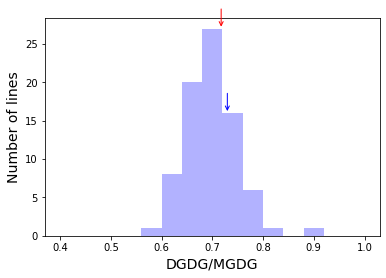

In [10]:
#lipid 
plt.figure()
bins = 15
para = 'DGDG/MGDG'
hist_with_arrows(df[para],range =[0.4,1],color='blue',alpha=0.3,bins =bins)

plt.xlabel(para, fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig('ratio',dpi=600)
plt.show()

PG_16_0
	mean: 30.555
	std: 1.756



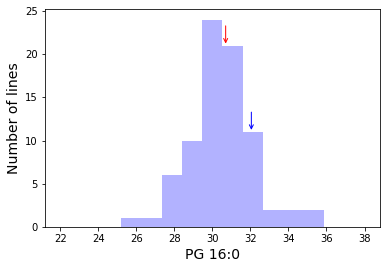

In [33]:
#fatty acid
plt.figure()
bins = 15
para = 'PG_16_0'
hist_with_arrows(df[para],range =[22,38],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PG 16:0', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PG_16_1
	mean: 32.909
	std: 1.998



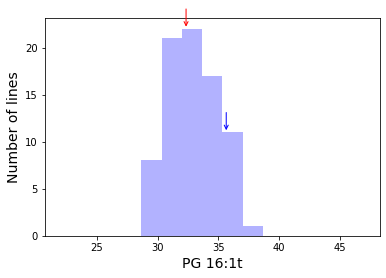

In [34]:
#fatty acid
plt.figure()
bins = 15
para = 'PG_16_1'
hist_with_arrows(df[para],range =[22,47],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PG 16:1t', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PEPI_18_1
	mean: 2.518
	std: 0.450



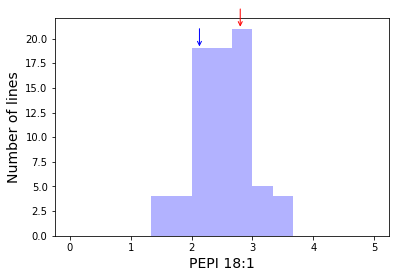

In [35]:
#fatty acid
plt.figure()
bins = 15
para = 'PEPI_18_1'
hist_with_arrows(df[para],range =[0,5],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PEPI 18:1', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

MGDG_16_0
	mean: 1.504
	std: 0.257



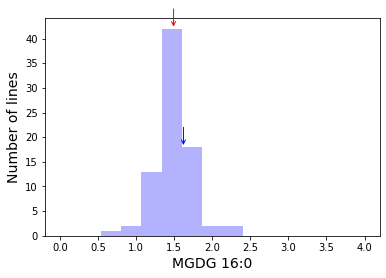

In [36]:
#fatty acid
plt.figure()
bins = 15
para = 'MGDG_16_0'
hist_with_arrows(df[para],range =[0,4],color='blue',alpha=0.3,bins =bins)

plt.xlabel('MGDG 16:0', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

MGDG_18_2
	mean: 2.653
	std: 0.406



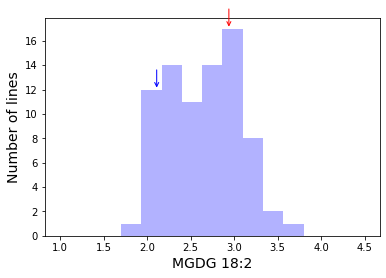

In [37]:
#fatty acid
plt.figure()
bins = 15
para = 'MGDG_18_2'
hist_with_arrows(df[para],range =[1,4.5],color='blue',alpha=0.3,bins =bins)

plt.xlabel('MGDG 18:2', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

MGDG_18_3
	mean: 95.122
	std: 0.589



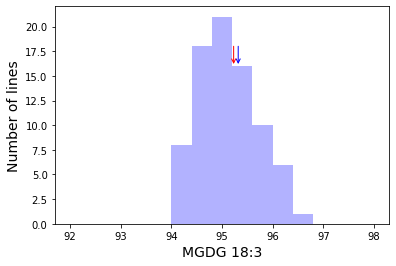

In [38]:
#fatty acid
plt.figure()
bins = 15
para = 'MGDG_18_3'
hist_with_arrows(df[para],range =[92,98],color='blue',alpha=0.3,bins =bins)

plt.xlabel('MGDG 18:3', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

DGDG_16_0
	mean: 8.096
	std: 0.886



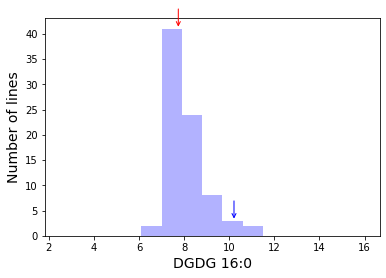

In [39]:
#fatty acid
plt.figure()
bins = 15
para = 'DGDG_16_0'
hist_with_arrows(df[para],range =[2.5,16],color='blue',alpha=0.3,bins =bins)

plt.xlabel('DGDG 16:0', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

DGDG_18_2
	mean: 0.795
	std: 0.158



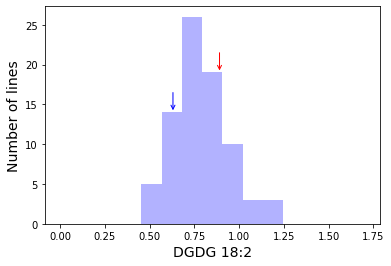

In [40]:
#fatty acid
plt.figure()
bins = 15
para = 'DGDG_18_2'
hist_with_arrows(df[para],range =[0,1.7],color='blue',alpha=0.3,bins =bins)

plt.xlabel('DGDG 18:2', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

DGDG_18_3
	mean: 89.868
	std: 1.149



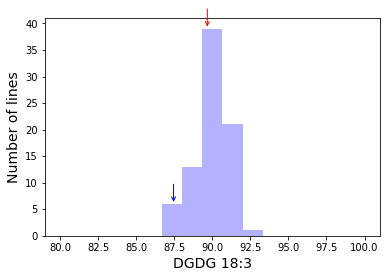

In [41]:
#fatty acid
plt.figure()
bins = 15
para = 'DGDG_18_3'
hist_with_arrows(df[para],range =[80,100],color='blue',alpha=0.3,bins =bins)

plt.xlabel('DGDG 18:3', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PG_18_2
	mean: 3.367
	std: 0.374



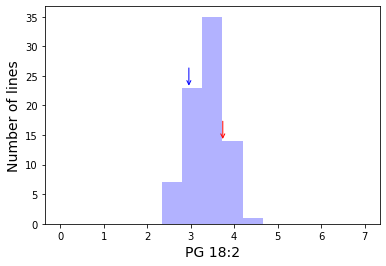

In [42]:
#fatty acid
plt.figure()
bins = 15
para = 'PG_18_2'
hist_with_arrows(df[para],range =[0,7],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PG 18:2', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PG_18_0
	mean: 2.444
	std: 0.244



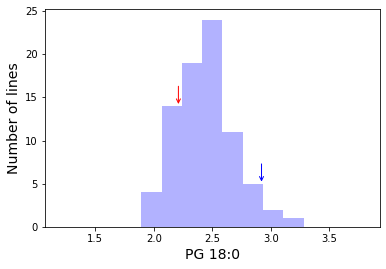

In [43]:
#fatty acid
plt.figure()
bins = 15
para = 'PG_18_0'
hist_with_arrows(df[para],range =[1.2,3.8],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PG 18:0', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PG_18_3
	mean: 28.766
	std: 2.804



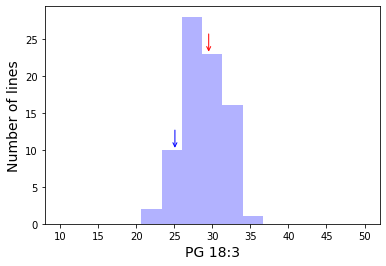

In [44]:
#fatty acid
plt.figure()
bins = 15
para = 'PG_18_3'
hist_with_arrows(df[para],range =[10,50],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PG 18:3', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PC_16_0
	mean: 19.484
	std: 1.386



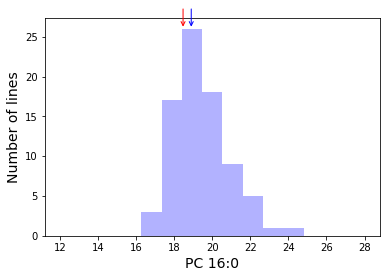

In [45]:
#fatty acid
plt.figure()
bins = 15
para = 'PC_16_0'
hist_with_arrows(df[para],range =[12,28],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PC 16:0', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PC_18_1
	mean: 4.117
	std: 1.772



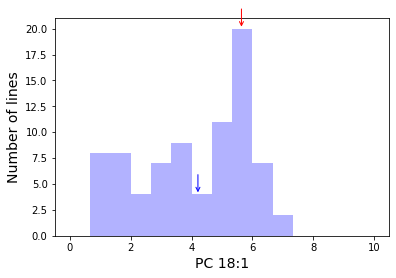

In [60]:
#fatty acid
plt.figure()
bins = 15
para = 'PC_18_1'
hist_with_arrows(df[para],range =[0,10],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PC 18:1', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PC_18_2
	mean: 39.426
	std: 1.844



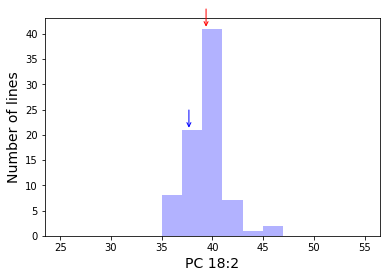

In [47]:
#fatty acid
plt.figure()
bins = 15
para = 'PC_18_2'
hist_with_arrows(df[para],range =[25,55],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PC 18:2', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PC_18_3
	mean: 33.893
	std: 1.812



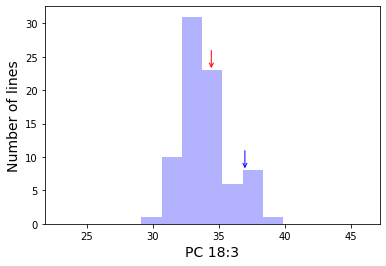

In [48]:
#fatty acid
plt.figure()
bins = 15
para = 'PC_18_3'
hist_with_arrows(df[para],range =[23,46],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PC 18:3', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PEPI_16_0
	mean: 30.996
	std: 1.486



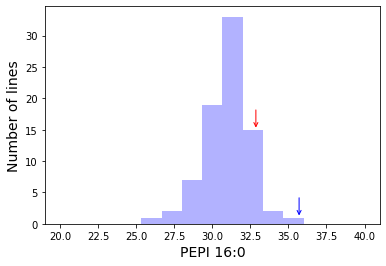

In [49]:
#fatty acid
plt.figure()
bins = 15
para = 'PEPI_16_0'
hist_with_arrows(df[para],range =[20,40],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PEPI 16:0', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PEPI_18_1
	mean: 2.518
	std: 0.450



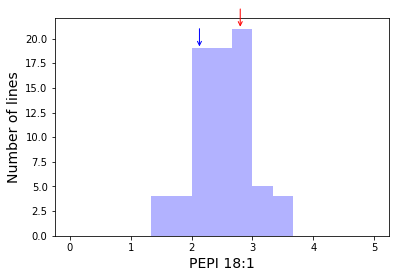

In [50]:
#fatty acid
plt.figure()
bins = 15
para = 'PEPI_18_1'
hist_with_arrows(df[para],range =[0,5],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PEPI 18:1', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PEPI_18_2
	mean: 33.393
	std: 1.367



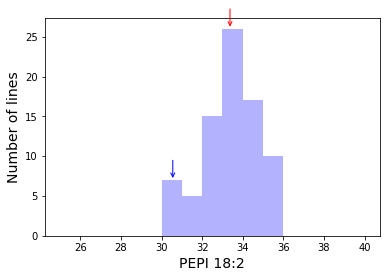

In [51]:
#fatty acid
plt.figure()
bins = 15
para = 'PEPI_18_2'
hist_with_arrows(df[para],range =[25,40],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PEPI 18:2', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

PEPI_18_3
	mean: 30.784
	std: 1.704



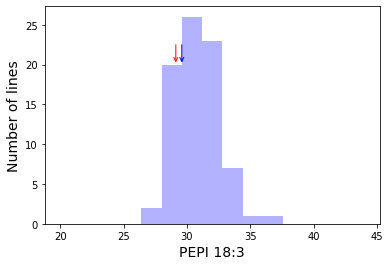

In [52]:
#fatty acid
plt.figure()
bins = 15
para = 'PEPI_18_3'
hist_with_arrows(df[para],range =[20,44],color='blue',alpha=0.3,bins =bins)

plt.xlabel('PEPI 18:3', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

SQDG_16_0
	mean: 34.145
	std: 1.917



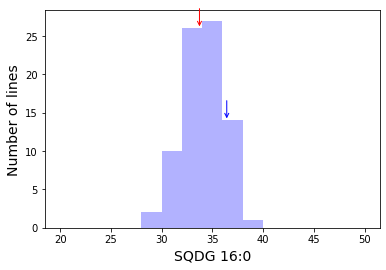

In [53]:
#fatty acid
plt.figure()
bins = 15
para = 'SQDG_16_0'
hist_with_arrows(df[para],range =[20,50],color='blue',alpha=0.3,bins =bins)

plt.xlabel('SQDG 16:0', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

SQDG_18_0
	mean: 3.148
	std: 0.407



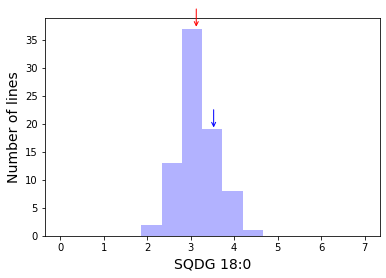

In [54]:
#fatty acid
plt.figure()
bins = 15
para = 'SQDG_18_0'
hist_with_arrows(df[para],range =[0,7],color='blue',alpha=0.3,bins =bins)

plt.xlabel('SQDG 18:0', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

SQDG_18_1
	mean: 1.775
	std: 0.405



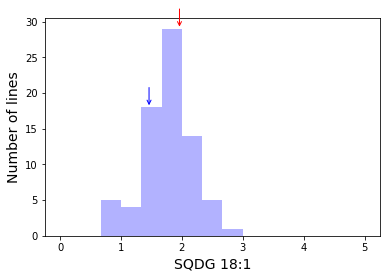

In [55]:
#fatty acid
plt.figure()
bins = 15
para = 'SQDG_18_1'
hist_with_arrows(df[para],range =[0,5],color='blue',alpha=0.3,bins =bins)

plt.xlabel('SQDG 18:1', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

SQDG_18_2
	mean: 7.028
	std: 1.416



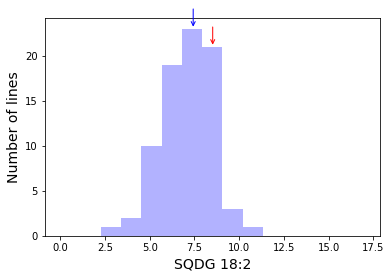

In [56]:
#fatty acid
plt.figure()
bins = 15
para = 'SQDG_18_2'
hist_with_arrows(df[para],range =[0,17],color='blue',alpha=0.3,bins =bins)

plt.xlabel('SQDG 18:2', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()

SQDG_18_3
	mean: 49.508
	std: 4.546



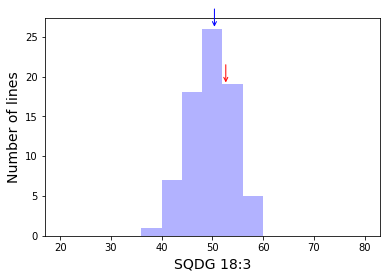

In [57]:
#fatty acid
plt.figure()
bins = 15
para = 'SQDG_18_3'
hist_with_arrows(df[para],range =[20,80],color='blue',alpha=0.3,bins =bins)

plt.xlabel('SQDG 18:3', fontsize=14)
plt.ylabel("Number of lines", fontsize=14)

plt.savefig(para,dpi=600)
plt.show()